# Exploratory Data analysis

About Dataset
Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents
Inspiration
To explore this type of models and learn more about the subject.

## Imports and settings

Import the libraries we'll use and set some display options for nicer outputs.

In [9]:
! pip install plotly missingno

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import os
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from lifelines import CoxPHFitter, KaplanMeierFitter

## Load dataset

We'll load the Telco Customer Churn CSV that is in the `data/` folder and show shape and the first rows.

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

csv_path = os.path.join("data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = pd.read_csv(csv_path)

print("Dataset path:", csv_path)
print("Shape:", df.shape)

df.head()

Dataset path: data\WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
print("Info:")
df.info()

print("\nMissing values per column:")
print(df.isna().sum())

print("\nUnique values for object dtypes:")
for col in df.select_dtypes(include="object").columns:
    print(col, ":", df[col].nunique())

print("\nDescribe (numeric):")
print(df.describe())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   ob

In [16]:
df_clean = df.copy()

df_clean["TotalCharges"] = df_clean["TotalCharges"].replace(" ", np.nan)
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

print("Missing TotalCharges after conversion:", df_clean["TotalCharges"].isna().sum())
if df_clean["TotalCharges"].isna().sum() > 0:
    display(df_clean[df_clean["TotalCharges"].isna()].head())

print("\nValue counts of tenure==0 among TotalCharges NA:")
print((df_clean[df_clean["TotalCharges"].isna()]["tenure"] == 0).sum())

df_clean["TotalCharges_filled"] = df_clean["TotalCharges"].fillna(
    df_clean["MonthlyCharges"] * df_clean["tenure"]
)

print("\nDone conversion. Using `df_clean` going forward for EDA.")

Missing TotalCharges after conversion: 11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No



Value counts of tenure==0 among TotalCharges NA:
11

Done conversion. Using `df_clean` going forward for EDA.


## Churn distribution and numeric variable plots

Explore churn counts and distributions for tenure, MonthlyCharges, and TotalCharges_filled.

Churn
No     5174
Yes    1869
Name: count, dtype: int64


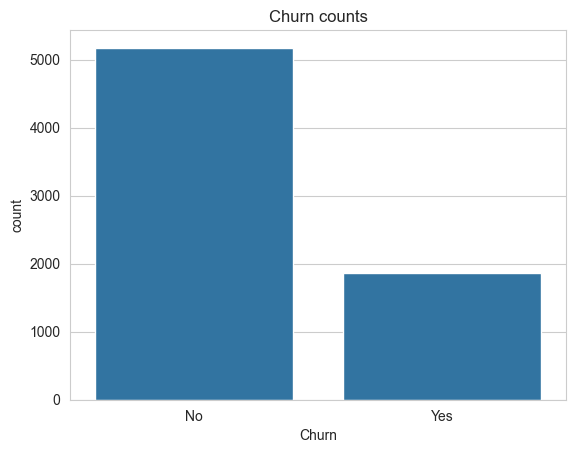

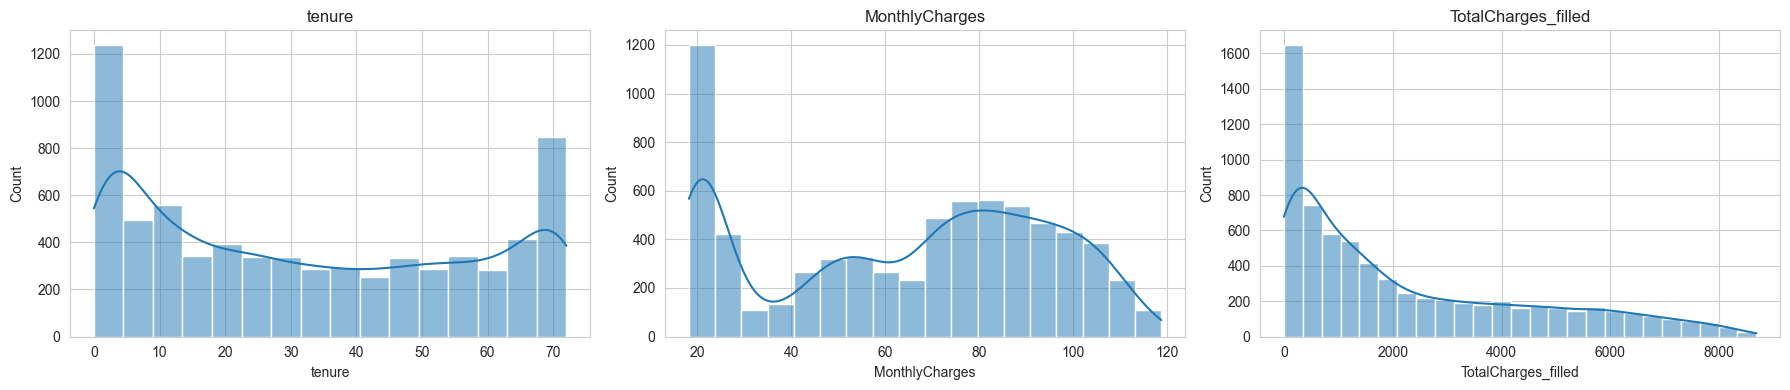

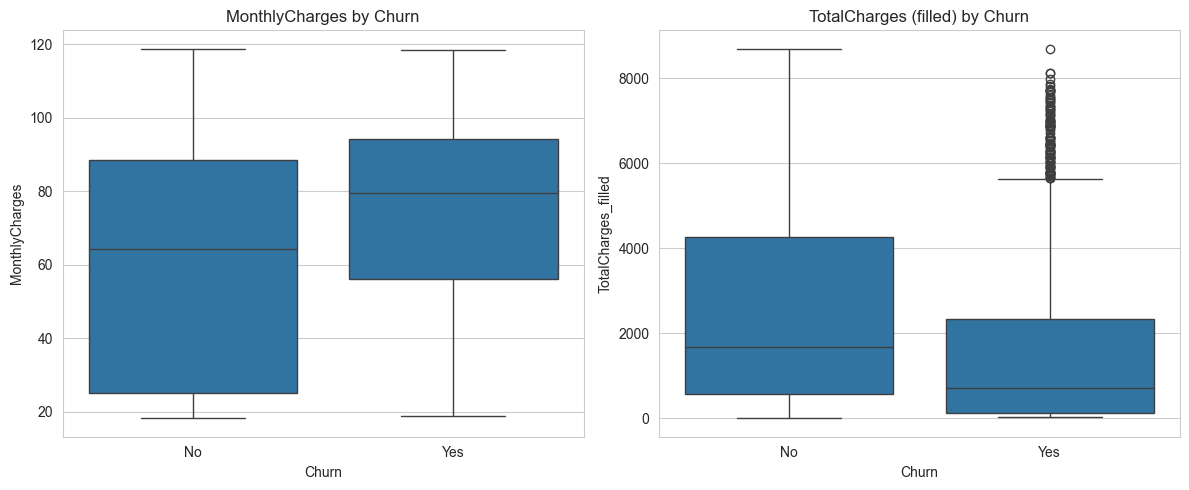

In [17]:
print(df_clean["Churn"].value_counts())
ax = sns.countplot(data=df_clean, x="Churn")
ax.set_title("Churn counts")

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges_filled"]
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for col, ax in zip(numeric_cols, axes):
    sns.histplot(df_clean[col].dropna(), kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df_clean, ax=axes[0])
axes[0].set_title("MonthlyCharges by Churn")
sns.boxplot(x="Churn", y="TotalCharges_filled", data=df_clean, ax=axes[1])
axes[1].set_title("TotalCharges (filled) by Churn")
plt.tight_layout()

## Categorical counts (selected columns)

Plot counts for some important categorical variables: `Contract`, `PaymentMethod`, `InternetService`, `gender`, `SeniorCitizen`, `Partner`, `Dependents`.

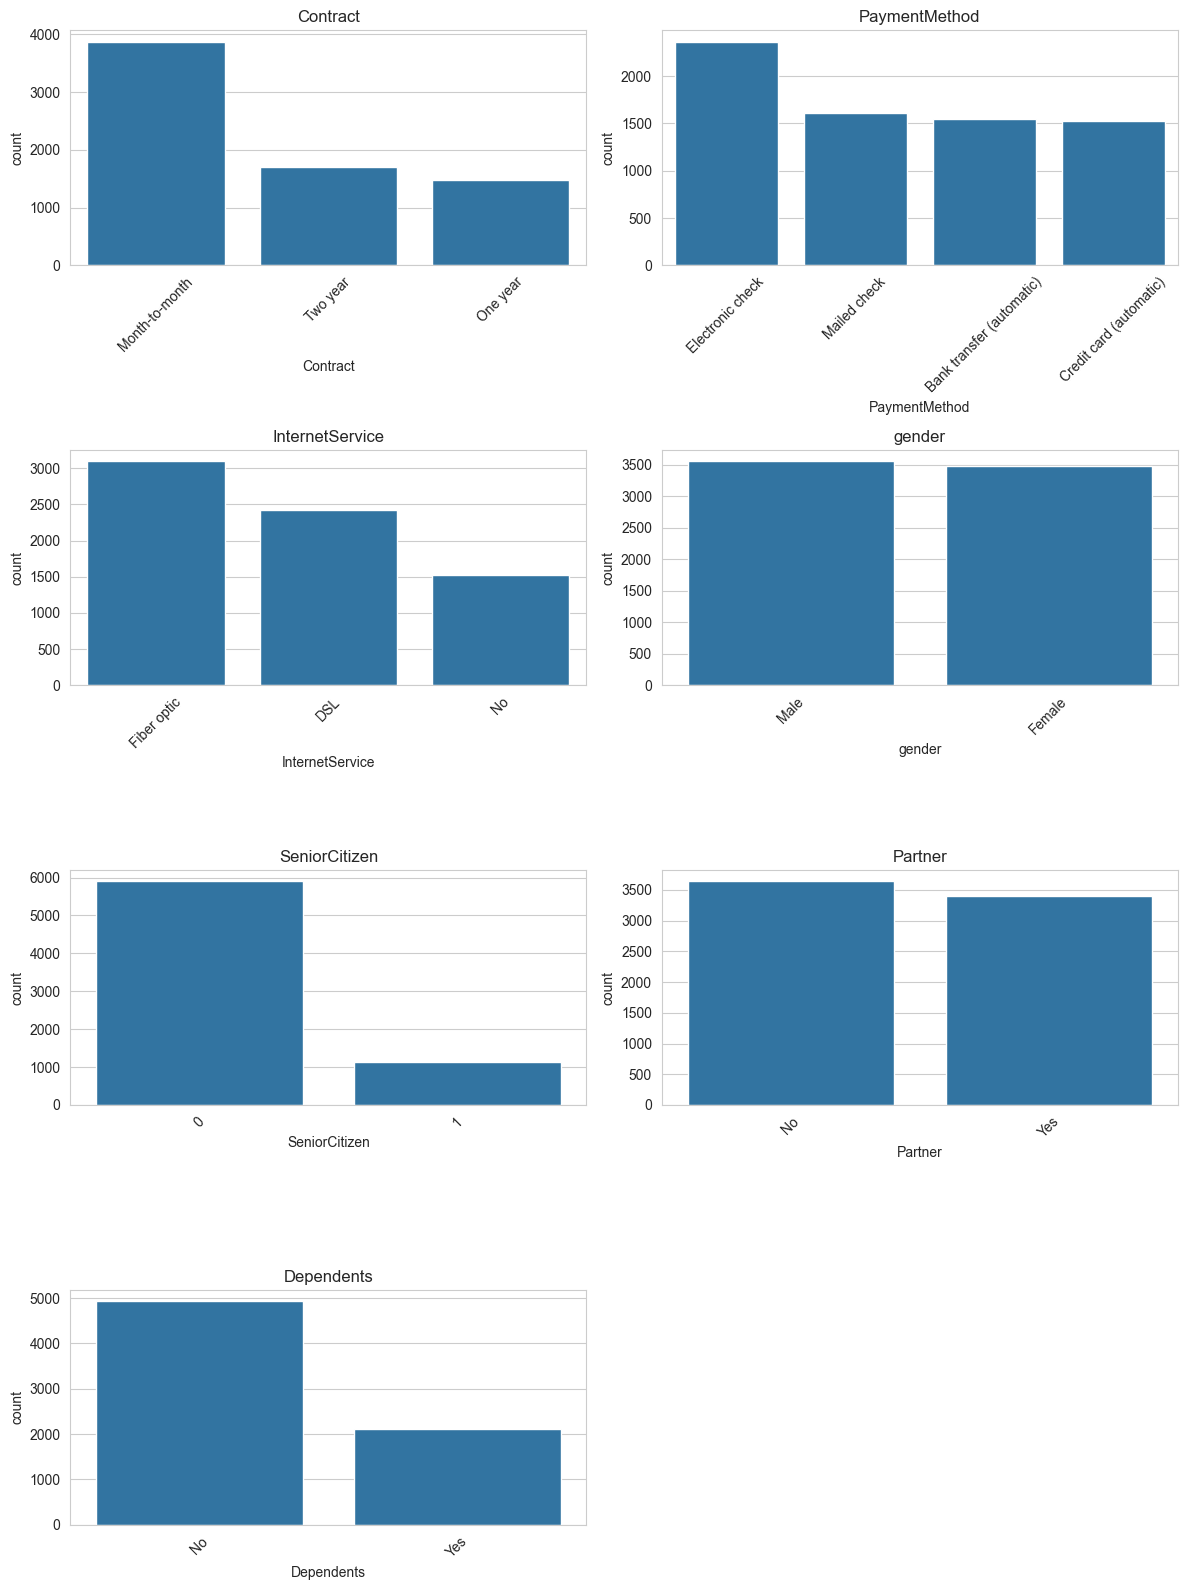

In [18]:
cat_cols = [
    "Contract",
    "PaymentMethod",
    "InternetService",
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
]

ncols = 2
nrows = int(np.ceil(len(cat_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()
for ax, col in zip(axes, cat_cols):
    order = df_clean[col].value_counts().index
    sns.countplot(data=df_clean, x=col, order=order, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis="x", rotation=45)

for ax in axes[len(cat_cols) :]:
    ax.set_visible(False)
plt.tight_layout()

## Correlation heatmap (numeric features)

Show correlations between numeric features (tenure, MonthlyCharges, TotalCharges_filled).

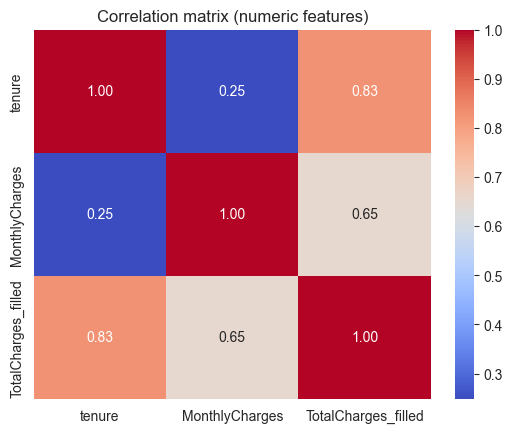

In [19]:
num_for_corr = ["tenure", "MonthlyCharges", "TotalCharges_filled"]
corr = df_clean[num_for_corr].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix (numeric features)")
plt.show()

In [ ]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


try:
    if "df" not in locals() or "TotalCharges" not in df.columns:
        df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
        df.dropna(subset=["TotalCharges"], inplace=True)
except NameError:
    print("Error: 'df' not found. Please run your initial data loading cell first.")
    df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df.dropna(subset=["TotalCharges"], inplace=True)


df_class = df.drop(["customerID"], axis=1, errors="ignore")

categorical_cols = df_class.select_dtypes(include=["object", "category"]).columns
target = "Churn"
categorical_cols = categorical_cols.drop(target)

df_class_processed = pd.get_dummies(df_class, columns=categorical_cols, drop_first=True)

df_class_processed["Churn"] = df_class_processed["Churn"].apply(
    lambda x: 1 if x == "Yes" else 0
)

print(f"Data shape for classification: {df_class_processed.shape}")

y = df_class_processed["Churn"]
X = df_class_processed.drop("Churn", axis=1)
num_features_class = ["tenure", "MonthlyCharges", "TotalCharges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler_class = StandardScaler()
X_train[num_features_class] = scaler_class.fit_transform(X_train[num_features_class])
X_test[num_features_class] = scaler_class.transform(X_test[num_features_class])

print("Data split and scaled.")

print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)
rf_model.fit(X_train, y_train)

print("Evaluating model...")
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Plotting feature importances...")
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

plt.figure(figsize=(12, 8))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title("Top 15 Feature Importances for Churn Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()